# Retail Sales Prediction - Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
data = pd.read_csv('final_df1.csv')

## Spliting data into train and test sets

In [3]:
X = data.drop('Weekly_Sales', axis = 1)
y = data.Weekly_Sales

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [5]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((296327, 63), (296327,), (126998, 63), (126998,))

## Scaling data

In [6]:
# Scaling: fit and transforming X_train & applying the same scaler to transform X_test
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

## Linear Regression Model 1

In [7]:
# Fitting training data in the regression model

from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train_norm, y_train)

LinearRegression()

In [8]:
y_pred = lm.predict(X_test_norm)

In [9]:
from sklearn.metrics import  mean_squared_error

mse_lm = mean_squared_error(y_test, y_pred)

print('mse: {}'.format(mse_lm))

mse: 3.5367170826214874e-27


In [10]:
from sklearn.model_selection import cross_val_score
mse = cross_val_score(lm, X_train_norm, y_train, scoring = 'neg_mean_squared_error', cv = 5)

In [11]:
mse

array([-1.96324338e-27, -6.66593753e-27, -7.75811414e-27, -1.62495678e-27,
       -1.67143532e-27])

In [12]:
lm.score(X_test_norm, y_test)

1.0

In [13]:
lm_coefs = lm.coef_

In [14]:
feat_names = X.columns

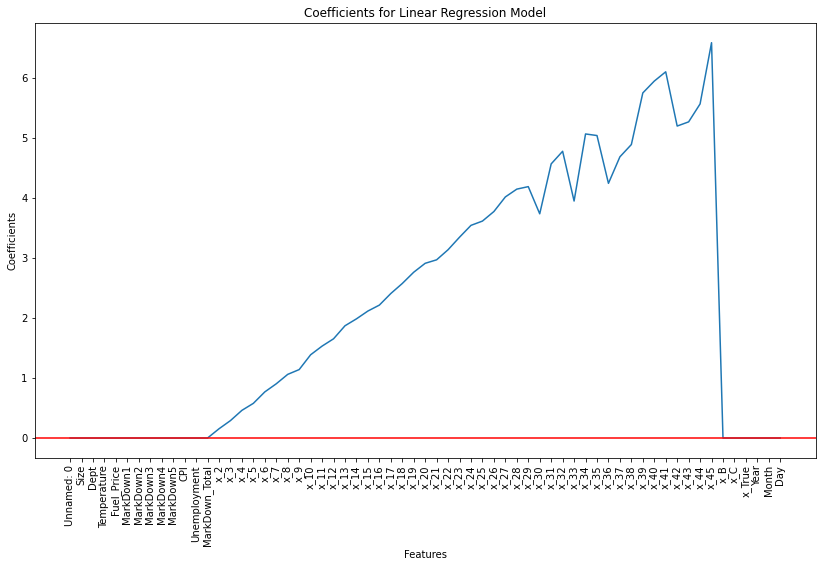

In [17]:
f, ax = plt.subplots(figsize = (14,8))
plt.plot(range(len(lm_coefs)), lm_coefs)
plt.axhline(0, color = 'r', linestyle = 'solid')
plt.xticks(range(len(feat_names)), feat_names, rotation = 90)
plt.title('Coefficients for Linear Regression Model')
plt.ylabel('Coefficients')
plt.xlabel('Features')
plt.show()

Though the performance of the Linear Model appears very good, we want to check features importance to understand what factors contribute to model predictions:

The only factors having sigificant impact on the sales are the different stores, others factors such as dThe  temperature, if there is a markdown or ,ot, CPI, unemplpyment, period of the year doesnt have much effect.

We will simplify the model by removing those features and creating a second Linear Model to fit the data

## Linear Regression Model 2

In [19]:
#
X_train_short = X_train_norm.drop(['Unnamed: 0', 'Size', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1',
       'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'MarkDown_Total', 'x_B', 'x_C', 'x_True', 'Year', 'Month', 'Day'], axis = 1)

X_test_short = X_test_norm.drop(['Unnamed: 0', 'Size', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1',
       'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'MarkDown_Total', 'x_B', 'x_C', 'x_True', 'Year', 'Month', 'Day'], axis = 1)

In [20]:
X_train_short.shape, X_test_short.shape

((296327, 44), (126998, 44))

In [21]:
lm2 = LinearRegression()
lm2.fit(X_train_short, y_train)
y_pred = lm2.predict(X_test_short)

In [53]:
mse_lm2 = mean_squared_error(y_test, y_pred)

print('mse: {}'.format(mse_lm2))

mse: 27.679475091700922


During the EDA phase, we noticed some collinearatity effects:
    - Temperature and fuel price: 14%
    - CPI and temperature: 18%
    - Mardown 1 and mardown 4: 82%

Also the total mardown which is naturally correlated with most mardowns but few appeared to have more weight in the total markdown (1,2,3,4,5)

To correct for these multicollinearity effect amongst variables, we will use some regularization techniques: Ridge, Lasso and Elastic Net and compare their performance vs the simple regression model

## Ridge Regression

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
alpha = {'alpha': [0.001, 0.01, 0.02]}
ridge = GridSearchCV(Ridge(), alpha, scoring = 'neg_mean_squared_error', cv = 5)

In [24]:
ridge.fit(X_train_short, y_train)

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [0.001, 0.01, 0.02]},
             scoring='neg_mean_squared_error')

In [25]:
ridge.best_params_

{'alpha': 0.001}

In [26]:
ridge.best_score_

-3.237305448464292e-13

In [27]:
ridge_coefs = ridge.best_estimator_.coef_

In [28]:
y_pred = ridge.predict(X_test_short)

## Lasso Regression

In [29]:
from sklearn.linear_model import Lasso
alpha = {'alpha': [0.001, 0.01, 0.02]}
lasso = GridSearchCV(Ridge(), alpha, scoring = 'neg_mean_squared_error', cv = 5)

In [30]:
lasso.fit(X_train_short, y_train)

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [0.001, 0.01, 0.02]},
             scoring='neg_mean_squared_error')

In [31]:
lasso.best_params_

{'alpha': 0.001}

In [32]:
lasso.best_score_

-3.237305448464292e-13

In [35]:
lasso_coefs = ridge.best_estimator_.coef_

In [37]:

table = pd.DataFrame({'linear_model': lm2.coef_, 'ridge': ridge_coefs, 'lasso': lasso_coefs}, 
                     index = X_train_short.columns)
table.head()

,linear_model,ridge,lasso
x_2,0.154013,0.154012,0.154012
x_3,0.290377,0.290376,0.290376
x_4,0.461037,0.461036,0.461036
x_5,0.577854,0.577853,0.577853
x_6,0.768447,0.768446,0.768446


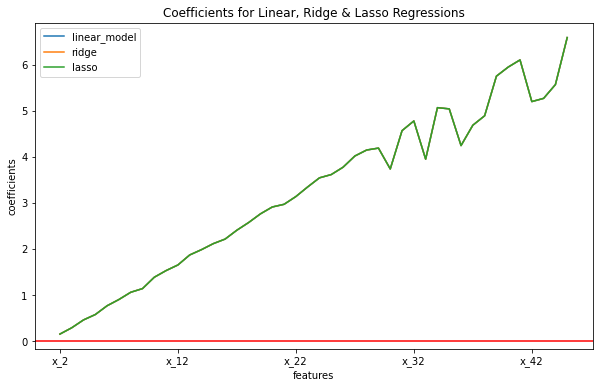

In [38]:
table.plot(figsize=(10, 6))
plt.axhline(0, color='r', linestyle='solid')
plt.title("Coefficients for Linear, Ridge & Lasso Regressions")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.show()

## Random Forest Model

In [39]:
# Hyperparameter search using GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

In [40]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree

random_grid = {'n_estimators': n_estimators,'max_features': max_features,
               'max_depth': max_depth}

In [41]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5)

In [42]:
rf_random.fit( X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19,
                                                         20]})

In [43]:
rf_random.best_params_

{'n_estimators': 11, 'max_features': 'auto', 'max_depth': 40}

In [44]:
best_rf = RandomForestRegressor(n_estimators = 4, max_features = 'auto', max_depth = 30)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=4)

In [45]:
y_pred = best_rf.predict(X_test)

In [46]:
mse_rf = mean_squared_error(y_test, y_pred)

print('mse: {}'.format(mse_rf))

mse: 0.00016830973716121513


## Gradient Boosting Model

In [47]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 12, 'max_depth': 80,
         'learning_rate':0.01, 'loss':'mse'}
gbr = GradientBoostingRegressor()

In [48]:
gbr.fit(X_train_short, y_train)

GradientBoostingRegressor()

In [49]:
y_pred = gbr.predict(X_test_short)

In [50]:
mse_gbr = mean_squared_error(y_test, y_pred)

print('mse: {}'.format(mse_gbr))

mse: 27.679475091700922


In [51]:
gbr.score(X_test_short, y_pred)

1.0

## Comparing models performance

In [76]:
d =  {'model': ['mse_lm', 'mse_lm2', 'mse_rf', 'mse_gbr', 'mse_ridge',
                           'mse_lasso'], 'mse_score': [mse_lm, mse_lm2, mse_rf, mse_gbr, ridge.best_score_, lasso.best_score_]}
perf= pd.DataFrame(d)

In [78]:
perf.sort_values(by = ['mse_score'], ascending = False)

,model,mse_score
1,mse_lm2,2.767948e+01
3,mse_gbr,2.767948e+01
2,mse_rf,1.683097e-04
0,mse_lm,3.536717e-27
4,mse_ridge,-3.237305e-13
5,mse_lasso,-3.237305e-13


## Conclusions

The random forest model provides the best predictions with the minimal mean squared error.